In [36]:
import pandas as pd
import numpy as np
!pip install transformers sentence-transformers torch --quiet


#učitavanje dataseta direktno sa GitHub-a
url = "https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv"
df = pd.read_csv(url)

In [37]:
#prikaz prvih 5 redova
df.head()
#osnovne informacije o kolonama
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country.of.Origin      1310 non-null   object 
 4   Farm.Name              955 non-null    object 
 5   Lot.Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO.Number             1163 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag.Weight             1311 non-null   object 
 14  In.Country.Partner     1311 non-null   object 
 15  Harv

In [38]:
#Provera nedostajućih vrednosti
df.isnull().sum()


,0
Unnamed: 0,0
Species,0
Owner,7
Country.of.Origin,1
Farm.Name,356
Lot.Number,1041
Mill,310
ICO.Number,148
Company,209
Altitude,223


In [39]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import StandardScaler

import numpy as np

# tekstualne kolone koje su ulaz u BERT
df['text_for_bert'] = df[['Region', 'Processing.Method']].fillna("").agg(" ".join, axis=1)

# Priprema numeričkih kolona
numericke_kolone = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'altitude_mean_meters']
X_numeric = df[numericke_kolone].fillna(0)




In [41]:
# Skaliranje numeričkih podataka
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Učitavanje BERT modela
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Funkcija za dobijanje embeddinga za tekst
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# BERT embedding za sve redove
bert_embeddings = np.array([get_embedding(t) for t in df['text_for_bert']])

# spajanje numeričke + tekstualne podatke
X_combined = np.hstack([X_numeric_scaled, bert_embeddings])

In [42]:
#Biramo samo korisne kolone
relevantne_kolone = [
    'Country.of.Origin', 'Processing.Method', 'altitude_mean_meters',
    'Acidity', 'Aroma', 'Flavor', 'Aftertaste', 'Body', 'Balance', 'Uniformity',
    'Total.Cup.Points'
]

df_clean = df[relevantne_kolone].dropna()

In [43]:
#pravi 3 nove kategorije ocene kvaliteta kafe i brise originalnu

def oceni_kafu(score):
    if score < 80:
        return 'loša'
    elif score < 85:
        return 'srednja'
    else:
        return 'vrhunska'

df_clean['kategorija_kvaliteta'] = df_clean['Total.Cup.Points'].apply(oceni_kafu)
df_clean = df_clean.drop(columns=['Total.Cup.Points'])


In [44]:
#uklanjanje originalne kolone sa ocenom

df_encoded = pd.get_dummies(df_clean)

#Pravimo X i y
X = df_encoded.drop(columns=['kategorija_kvaliteta_loša', 'kategorija_kvaliteta_srednja', 'kategorija_kvaliteta_vrhunska'], errors='ignore')
y = df_encoded[['kategorija_kvaliteta_loša', 'kategorija_kvaliteta_srednja', 'kategorija_kvaliteta_vrhunska']]

In [45]:
#Priprema ulaza i glavne promenljive
X = df_encoded.drop(columns=['kategorija_kvaliteta_loša', 'kategorija_kvaliteta_srednja', 'kategorija_kvaliteta_vrhunska'], errors='ignore')
y = df_encoded[['kategorija_kvaliteta_loša', 'kategorija_kvaliteta_srednja', 'kategorija_kvaliteta_vrhunska']]

In [46]:
#trening i test set


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 60% trening / 40% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Standardizacija
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [47]:
#kreiranje i treniranje neuronske mreze

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#broj ulaznih osobina (broj kolona u X)

input_dim = X_combined.shape[1]

#kreiranje modela

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

#Kompajliranje modela

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#treniranje modela

history = model.fit(
    X_combined, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4743 - loss: 1.0540 - val_accuracy: 0.8512 - val_loss: 0.5191
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8378 - loss: 0.6088 - val_accuracy: 0.9174 - val_loss: 0.3653
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8415 - loss: 0.4079 - val_accuracy: 0.9256 - val_loss: 0.2599
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8961 - loss: 0.2558 - val_accuracy: 0.9256 - val_loss: 0.1995
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9206 - loss: 0.2145 - val_accuracy: 0.9256 - val_loss: 0.1815
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9423 - loss: 0.1745 - val_accuracy: 0.9339 - val_loss: 0.1647
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9462 - loss: 0.1636 - val_accuracy: 0.9669 - val_loss: 0.1456
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9432 - loss: 0.1486 - val_accuracy: 0.9339 - val_loss: 0.1435
Ep

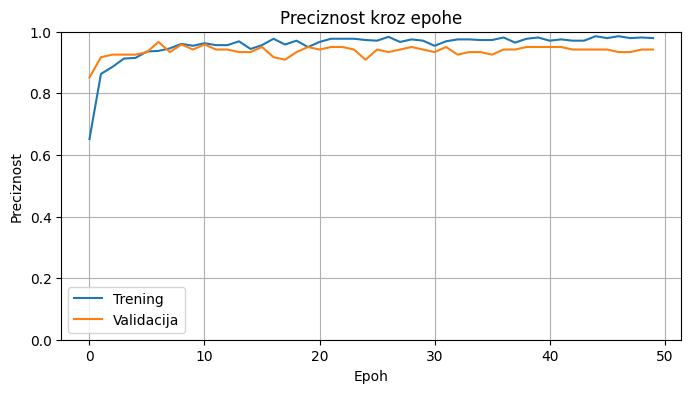

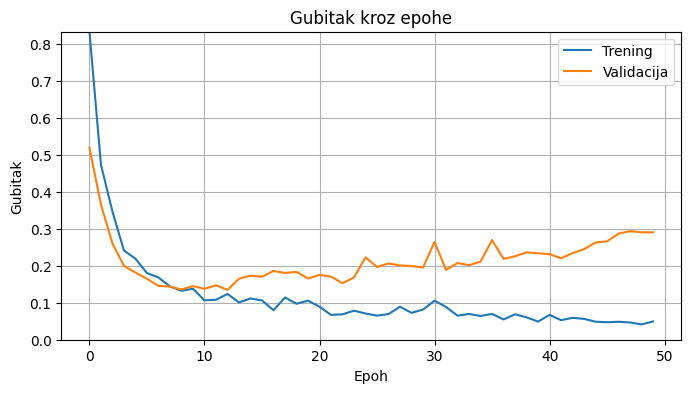

In [48]:
import matplotlib.pyplot as plt

# Preciznost
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Validacija')
plt.title('Preciznost kroz epohe')
plt.xlabel('Epoh')
plt.ylabel('Preciznost')
plt.ylim(0, 1)  # skaliranje y ose
plt.legend()
plt.grid(True)
plt.show()

# Gubitak
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Validacija')
plt.title('Gubitak kroz epohe')
plt.xlabel('Epoh')
plt.ylabel('Gubitak')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # dinamičko skaliranje
plt.legend()
plt.grid(True)
plt.show()


In [49]:
#Evaluacija na test skupu
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Tačnost na test skupu: {test_acc:.2f}")

Tačnost na test skupu: 0.14


In [50]:
#cuvanje modela u .h5 formatu
model.save("model_kvalitet_kafe.h5")
print("Model sačuvan kao model_kvalitet_kafe.h5")


Model sačuvan kao model_kvalitet_kafe.h5


In [51]:
#Uzmi jedan primer iz test skupa
import numpy as np

sample = X_test_scaled[0].reshape(1, -1)
prediction = model.predict(sample)

# Mapiranje rezultata nazad u klasu
klase = ['loša', 'srednja', 'vrhunska']
predicted_class = klase[np.argmax(prediction)]

print(f"Model predviđa da je kafa: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Model predviđa da je kafa: loša


In [52]:
#Predikcije za ceo test skup
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = [klase[np.argmax(row)] for row in y_pred_probs]

#cuvanje u csv file predikcije
df_rezultat = pd.DataFrame({
    'Predikcija': y_pred_classes
})
df_rezultat.to_csv("predikcije_kafe.csv", index=False)

print("Predikcije su sačuvane u predikcije_kafe.csv")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predikcije su sačuvane u predikcije_kafe.csv


Izveštaj klasifikacije:

              precision    recall  f1-score   support

           0       0.14      1.00      0.25        56
           1       0.00      0.00      0.00       320
           2       0.14      0.04      0.06        26

    accuracy                           0.14       402
   macro avg       0.09      0.35      0.10       402
weighted avg       0.03      0.14      0.04       402



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


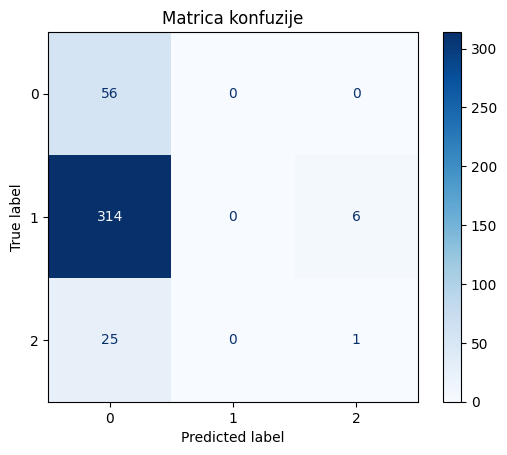

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

#Konverzija y_test iz one-hot u klase
y_test_classes = np.argmax(y_test, axis=1)

#Izveštaj klasifikacije
print("Izveštaj klasifikacije:\n")
print(classification_report(y_test_classes, y_pred_classes))

#Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrica konfuzije")
plt.show()

